In [100]:
import pygame
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import gym
from tqdm import trange
import matplotlib.pyplot as plt

In [101]:
class DeepQNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims, n_actions, device='mps'):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.lr = lr
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions

        self.fc1 = nn.Linear(input_dims, fc1_dims)
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.fc3 = nn.Linear(fc2_dims, n_actions)
        self.opt = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = device
        self.to(device)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [102]:
class Agent():
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions, max_men_size = 10000, eps_end = 0.01, eps_dec=5e-4):
        self.gamma = gamma
        self.epsilon = epsilon
        self.lr = lr
        self.input_dims = input_dims
        self.batch_size = batch_size
        self.n_actions = n_actions
        self.mem_size = max_men_size
        self.eps_end = eps_end
        self.eps_dec = eps_dec
        self.mem_cntr = 0
        self.action_space = [i for i in range(n_actions)]

        self.Q_eval = DeepQNetwork(self.lr, n_actions=n_actions, input_dims=input_dims, fc1_dims=256, fc2_dims=256)

        self.state_memory = np.zeros((self.mem_size, input_dims), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, input_dims), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=bool)
    
    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done

        self.mem_cntr += 1

    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            state = torch.tensor([observation]).to(self.Q_eval.device)
            actions = self.Q_eval(state)
            action = torch.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)
        
        return action

    def learn(self):
        if self.mem_cntr < self.batch_size:
            return
        
        self.Q_eval.opt.zero_grad()

        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, self.batch_size, replace = False)

        batch_index = np.arange(self.batch_size, dtype=np.int32)

        state_batch = torch.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = torch.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
        reward_batch = torch.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch = torch.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)

        action_batch = self.action_memory[batch]

        q_eval = self.Q_eval.forward(state_batch)[batch_index, action_batch]
        q_next = self.Q_eval.forward(new_state_batch)
        q_next[terminal_batch] = 0.0

        q_target = reward_batch + self.gamma * torch.max(q_next, dim=1)[0]

        loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
        loss.backward()
        self.Q_eval.opt.step()

        self.epsilon -= self.eps_dec

        self.epsilon = max(self.epsilon, self.eps_end)

In [103]:
env = gym.make('LunarLander-v2')
agent = Agent(gamma=0.99, epsilon=1.0, batch_size=64, n_actions=4, eps_end=0.01, input_dims=8, lr=0.001)

scores = []
for i in trange(500):
    score = 0
    done = False
    observation = env.reset()
    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        score += reward
        agent.store_transition(observation, action, reward, observation_, done)

        agent.learn()
        observation = observation_
    scores.append(score)

 47%|████▋     | 235/500 [17:28<12:00,  2.72s/it] 

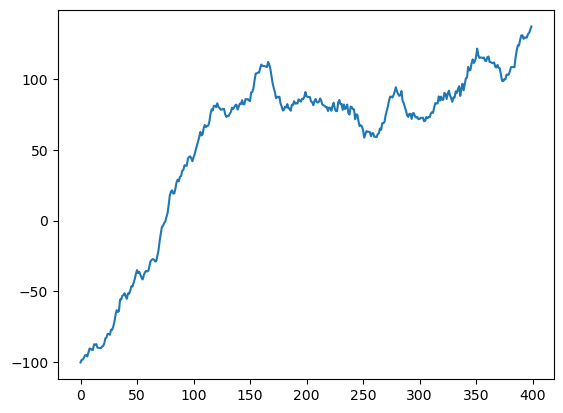

In [ ]:
t = []
for i in range(len(scores)-100):
    t.append(np.mean(scores[i:i+100]))
plt.plot(t)